In [1]:
# plots for paper

# import libraries
import math
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import time
import os
import glob

pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [6]:
def bulirsch_stoer_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z, N, h, q, p):
    # step 1: modified midpoint method with step size h
    x_values1, y_values1, z_values1, Vx_values1, Vy_values1, Vz_values1 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h)
    
    # step 2: modified midpoint method with step size h/q
    N_2 = int((timestep * q)/h)
    h_2 = h/q
    
    x_values2, y_values2, z_values2, Vx_values2, Vy_values2, Vz_values2 = modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N_2, h_2)
    
    # step 3: Richardson Extrapolation
    x_final = Richardson_extrapolation(x_values1, x_values2, q, p)
    y_final = Richardson_extrapolation(y_values1, y_values2, q, p)
    z_final = Richardson_extrapolation(z_values1, z_values2, q, p)
    
    Vx_final = Richardson_extrapolation(Vx_values1, Vx_values2, q, p)
    Vy_final = Richardson_extrapolation(Vy_values1, Vy_values2, q, p)
    Vz_final = Richardson_extrapolation(Vz_values1, Vz_values2, q, p)
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)


def Richardson_extrapolation(f_h, f_hq, q, p):
    return f_h + (f_h - f_hq)/((q**(-p)) -1)


def modified_midpoint_method_optimized(position, velocity, Fx, Fy, Fz, args_x, args_y, args_z, N, h):
    x_values = [None] * (N + 1)
    y_values = [None] * (N + 1)
    z_values = [None] * (N + 1)
    
    Vx_values = [None] * (N + 1)
    Vy_values = [None] * (N + 1)
    Vz_values = [None] * (N + 1)
    
    Fx_values = [None] * (N + 1)
    Fy_values = [None] * (N + 1)
    Fz_values = [None] * (N + 1)
    
    # prep
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 1
    # print("step:", 1)
    x_values[1] = x_values[0] + Vx_values[0] * h
    y_values[1] = y_values[0] + Vy_values[0] * h
    z_values[1] = z_values[0] + Vz_values[0] * h

    Vx_values[1] = Vx_values[0] + Fx_values[0] * h
    Vy_values[1] = Vy_values[0] + Fy_values[0] * h
    Vz_values[1] = Vz_values[0] + Fz_values[0] * h

    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])

    # steps 2 +
    for n in range(2, N+1):
        # print("step:", n)
        x_values[n] = x_values[n-2] + Vx_values[n-1] * 2 * h
        y_values[n] = y_values[n-2] + Vy_values[n-1] * 2 * h
        z_values[n] = z_values[n-2] + Vz_values[n-1] * 2 * h

        Vx_values[n] = Vx_values[n-2] + Fx_values[n-1] * 2 * h
        Vy_values[n] = Vy_values[n-2] + Fy_values[n-1] * 2 * h
        Vz_values[n] = Vz_values[n-2] + Fz_values[n-1] * 2 * h

        Fx_values[n] = Fx(args_x, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fy_values[n] = Fy(args_y, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
        Fz_values[n] = Fz(args_z, Vx_values[n], Vy_values[n], Vz_values[n], x_values[n], y_values[n], z_values[n])
    
    # final step
    x_values = 1/2 * (x_values[N] + x_values[N-1] + (h * Vx_values[N]))
    y_values = 1/2 * (y_values[N] + y_values[N-1] + (h * Vy_values[N]))
    z_values = 1/2 * (z_values[N] + z_values[N-1] + (h * Vz_values[N]))

    Vx_values = 1/2 * (Vx_values[N] + Vx_values[N-1] + (h * Fx_values[N]))
    Vy_values = 1/2 * (Vy_values[N] + Vy_values[N-1] + (h * Fy_values[N]))
    Vz_values = 1/2 * (Vz_values[N] + Vz_values[N-1] + (h * Fz_values[N]))
    
    return x_values, y_values, z_values, Vx_values, Vy_values, Vz_values


def runga_kutta_3d_optimized(position, velocity, timestep, Fx, Fy, Fz, args_x, args_y, args_z):
    x_values = [None] * 4
    y_values = [None] * 4
    z_values = [None] * 4
    
    Vx_values = [None] * 4
    Vy_values = [None] * 4
    Vz_values = [None] * 4
    
    Fx_values = [None] * 4
    Fy_values = [None] * 4
    Fz_values = [None] * 4
    
    # step 1
    x_values[0] = position[0]
    y_values[0] = position[1]
    z_values[0] = position[2]
    
    Vx_values[0] = velocity[0]
    Vy_values[0] = velocity[1]
    Vz_values[0] = velocity[2]
    
    Fx_values[0] = Fx(args_x, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fy_values[0] = Fy(args_y, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    Fz_values[0] = Fz(args_z, Vx_values[0], Vy_values[0], Vz_values[0], x_values[0], y_values[0], z_values[0])
    
    # step 2
    x_values[1] = x_values[0] + Vx_values[0] * timestep/2
    y_values[1] = y_values[0] + Vy_values[0] * timestep/2
    z_values[1] = z_values[0] + Vz_values[0] * timestep/2
    
    Vx_values[1] = Vx_values[0] + Fx_values[0] * timestep/2
    Vy_values[1] = Vy_values[0] + Fy_values[0] * timestep/2
    Vz_values[1] = Vz_values[0] + Fz_values[0] * timestep/2
    
    Fx_values[1] = Fx(args_x, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fy_values[1] = Fy(args_y, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    Fz_values[1] = Fz(args_z, Vx_values[1], Vy_values[1], Vz_values[1], x_values[1], y_values[1], z_values[1])
    
    # step 3
    x_values[2] = x_values[0] + Vx_values[1] * timestep/2
    y_values[2] = y_values[0] + Vy_values[1] * timestep/2
    z_values[2] = z_values[0] + Vz_values[1] * timestep/2
    
    Vx_values[2] = Vx_values[0] + Fx_values[1] * timestep/2
    Vy_values[2] = Vy_values[0] + Fy_values[1] * timestep/2
    Vz_values[2] = Vz_values[0] + Fz_values[1] * timestep/2
    
    Fx_values[2] = Fx(args_x, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fy_values[2] = Fy(args_y, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    Fz_values[2] = Fz(args_z, Vx_values[2], Vy_values[2], Vz_values[2], x_values[2], y_values[2], z_values[2])
    
    # step 4
    x_values[3] = x_values[0] + Vx_values[2] * timestep
    y_values[3] = y_values[0] + Vy_values[2] * timestep
    z_values[3] = z_values[0] + Vz_values[2] * timestep
    
    Vx_values[3] = Vx_values[0] + Fx_values[2] * timestep
    Vy_values[3] = Vy_values[0] + Fy_values[2] * timestep
    Vz_values[3] = Vz_values[0] + Fz_values[2] * timestep
    
    Fx_values[3] = Fx(args_x, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fy_values[3] = Fy(args_y, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    Fz_values[3] = Fz(args_z, Vx_values[3], Vy_values[3], Vz_values[3], x_values[3], y_values[3], z_values[3])
    
    # step 5
    x_final = x_values[0] + ((Vx_values[0] + 2*Vx_values[1] + 2*Vx_values[2] + Vx_values[3])*timestep)/6
    y_final = y_values[0] + ((Vy_values[0] + 2*Vy_values[1] + 2*Vy_values[2] + Vy_values[3])*timestep)/6
    z_final = z_values[0] + ((Vz_values[0] + 2*Vz_values[1] + 2*Vz_values[2] + Vz_values[3])*timestep)/6
    
    Vx_final = Vx_values[0] + ((Fx_values[0] +2*Fx_values[1] +2*Fx_values[2] + Fx_values[3])*timestep)/6
    Vy_final = Vy_values[0] + ((Fy_values[0] +2*Fy_values[1] +2*Fy_values[2] + Fy_values[3])*timestep)/6
    Vz_final = Vz_values[0] + ((Fz_values[0] +2*Fz_values[1] +2*Fz_values[2] + Fz_values[3])*timestep)/6
    
    return (x_final, y_final, z_final), (Vx_final, Vy_final, Vz_final)

In [7]:
def gravitational_force(args, Vx, Vy, Vz, x, y, z):
    n = args[0] # position of body in array of all bodies
    m = args[1] # mass array
    component = args[2] # "x", "y", or "z"
    x_all = args[3] # last x position of all bodies (array)
    y_all = args[4] # last x position of all bodies (array)
    z_all = args[5] # last x position of all bodies (array)
    G_or_const = args[6]
    
    F = 0

    for body in range(len(x_all)):
        if body != n:
            # claculate distance between 2 bodies
            r =  math.sqrt((x_all[body] - x)**2 + (y_all[body] - y)**2 + (z_all[body] - z)**2)
            # print("r:", r)
            if component == "x":
                F -= G_or_const * m[body] * ((x - x_all[body])/r**3)
            elif component == "y":
                F -= G_or_const * m[body] * ((y - y_all[body])/r**3)
            elif component == "z":
                F -= G_or_const * m[body] * ((z - z_all[body])/r**3)      
    return F

def run_simulation(input_file, n_timesteps, timestep, func_integration, args, return_velocity):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities
    x = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vx = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vy = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    Vz = [[None] * (n_timesteps + 1) for _ in range(n_bodies)]
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]] 
        x[n][0] = float(row.x)/AU
        y[n][0] = float(row.y)/AU
        z[n][0] = float(row.z)/AU

        Vx[n][0] = float(row.Vx)*(year/AU)
        Vy[n][0] = float(row.Vy)*(year/AU)
        Vz[n][0] = float(row.Vz)*(year/AU)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(n_timesteps):
        # set array with latest position for all bodies
        x_last_all = [None] * n_bodies
        y_last_all = [None] * n_bodies
        z_last_all = [None] * n_bodies
        
        for n in range(n_bodies):
            x_last_all[n] = x[n][t]
            y_last_all[n] = y[n][t]
            z_last_all[n] = z[n][t]
            
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x_last_all[n], y_last_all[n], z_last_all[n])
            v_components = (Vx[n][t], Vy[n][t], Vz[n][t])

            args_x = (n, m, "x", x_last_all, y_last_all, z_last_all, norm_const)
            args_y = (n, m, "y", x_last_all, y_last_all, z_last_all, norm_const)
            args_z = (n, m, "z", x_last_all, y_last_all, z_last_all, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # add new value in arrays
            x[n][t+1] = p_components[0]
            y[n][t+1] = p_components[1]
            z[n][t+1] = p_components[2]

            Vx[n][t+1] = v_components[0]
            Vy[n][t+1] = v_components[1]
            Vz[n][t+1] = v_components[2]
            
    exec_time = time.time() - start_time
    if return_velocity == True:
        return n_bodies, bodies, x, y, z, exec_time, Vx, Vy, Vz
    return n_bodies, bodies, x, y, z, exec_time

# instead of keeping all positions in memory in array, this function stores positions in files
def run_simulation_save(input_file, n_timesteps, timestep, func_integration, args, folder, step_save):
    df = pd.read_csv(input_file)
    bodies = list(df['body'])
    df = df.set_index('body')
    n_bodies = len(df)
    # print(n_bodies, "bodies:", bodies)
    display(df)
    
    # set array of masses and normalize
    m = list(df["mass"])
    m = [i/mass_sun for i in m]
    # print("Masses:", m)

    # initialization positions and velocities in temporary arrays (changed at each step)
    x = [None] * n_bodies
    y = [None] * n_bodies
    z = [None] * n_bodies
    Vx = [None] * n_bodies
    Vy = [None] * n_bodies
    Vz = [None] * n_bodies
    
    # initiaization folder
    create_empty_folder(folder)
    
    for n in range(n_bodies):
        row = df.loc[bodies[n]]
        x[n] = row.x/AU
        y[n] = row.y/AU
        z[n] = row.z/AU

        Vx[n] = row.Vx*(year/AU)
        Vy[n] = row.Vy*(year/AU)
        Vz[n] = row.Vz*(year/AU)
    # save
    save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, 0)
    
    if func_integration == "Bulirsch-Stoer" or func_integration == "Bulirsch-Stoer_optimized":
        N = args[0]
        h = args[1]
        q = args[2]
        p = args[3]
    
    start_time = time.time()
    # run simulation
    for t in range(1, n_timesteps + 1):
    
        for n in range(n_bodies):
            # for a specific body: p_components are its position, c_components are its velocity components
            p_components = (x[n], y[n], z[n])
            v_components = (Vx[n], Vy[n], Vz[n])

            args_x = (n, m, "x", x, y, z, norm_const)
            args_y = (n, m, "y", x, y, z, norm_const)
            args_z = (n, m, "z", x, y, z, norm_const)
            
            if func_integration == "Bulirsch-Stoer":
                p_components, v_components = bulirsch_stoer_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Bulirsch-Stoer_optimized":
                p_components, v_components = bulirsch_stoer_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z, N, h, q, p)  
            elif func_integration == "Runga-Kutta":
                p_components, v_components = runga_kutta_3d(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
            elif func_integration == "Runga-Kutta_optimized":
                p_components, v_components = runga_kutta_3d_optimized(p_components, v_components, timestep, gravitational_force, gravitational_force, gravitational_force, args_x, args_y, args_z)
        
            # save new values in arrays
            x[n] = p_components[0]
            y[n] = p_components[1]
            z[n] = p_components[2]

            Vx[n] = v_components[0]
            Vy[n] = v_components[1]
            Vz[n] = v_components[2]
            
        # save values in files
        if t % step_save == 0:
            save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, t)   
                 
    exec_time = time.time() - start_time
    return n_bodies, bodies, exec_time

def create_empty_folder(folder):
    if os.path.exists(folder):
        files = glob.glob(folder + '/*')
        for f in files:
            os.remove(f)
    else:
        os.mkdir(folder)

def save_timestep(bodies, x, y, z, Vx, Vy, Vz, folder, timestep):
    # create dataframe
    df = pd.DataFrame()
    df["body"] = bodies
    df["x"] = x
    df["y"] = y
    df["z"] = z
    df["Vx"] = Vx
    df["Vy"] = Vy
    df["Vz"] = Vz
    
    df.to_csv(folder + "/t_%s.csv"%(str(timestep)), index = False)

def get_positions_from_files(folder, timesteps, n_bodies):
    # position arrays
    n_timesteps = len(timesteps)
    x = [[None] * (n_timesteps) for _ in range(n_bodies)]
    y = [[None] * (n_timesteps) for _ in range(n_bodies)]
    z = [[None] * (n_timesteps) for _ in range(n_bodies)]
    
    # populate position arrays
    index = 0
    for timestep in timesteps:
        df = pd.read_csv(folder + "/t_%s.csv"%(str(timestep)))
        x_tmp = list(df["x"])
        y_tmp = list(df["y"])
        z_tmp = list(df["z"])
        
        for n in range(n_bodies):
            x[n][index] = x_tmp[n]
            y[n][index] = y_tmp[n]
            z[n][index] = z_tmp[n]  
        index += 1
        
    return x, y, z

In [8]:
# non-dimentionalize code
# universal gravitation constant
G = 6.67259e-20  # (km**3/kg/s**2)
mass_sun = 1.989e30 # kg
AU = 1.496e8 #km
year = 3.156e7 #s
norm_const = (G * mass_sun * (year**2))/(AU**3)
# print(norm_const)

In [9]:
input_file = "new_horizons_data_init_01_01_1750.csv"

n_days_timestep = 2 # timestep in number of days
n_days_total = 365 * 165 # total number of days I want to simulate
n_timesteps = int(n_days_total/n_days_timestep) # number of timesteps for simulation
print("Number of timesteps:", n_timesteps)

timestep = (86400/year) * n_days_timestep # (86400/year) = 1 day in non dimensional
print("Timestep:", timestep)

# variables for Bulirsch-Stoer method
N = 4
h = timestep/N
q = 2
p = 1

func_integration = "Bulirsch-Stoer_optimized" #"Runga-Kutta" "Bulisrsch-Stoer"  "Runga-Kutta_optimized"
args_bulirsch_stoer = [N, h, q, p]

Number of timesteps: 30112
Timestep: 0.005475285171102661


In [10]:
n_bodies, bodies, x, y, z, exec_time = run_simulation(input_file, n_timesteps, timestep, func_integration, args_bulirsch_stoer, False)
print(exec_time)
print(bodies)

print(len(x[0]))

,x,y,z,Vx,Vy,Vz,mass
body,,,,,,,
sun,-4.680e+05,1.518e+05,3.953e+03,-3.258e-04,-0.012,6.355e-05,1.989e+30
earth,-3.621e+07,1.428e+08,8.407e+04,-2.939e+01,-7.345,-5.444e-03,5.972e+24
jupiter,7.348e+08,8.784e+07,-1.688e+07,-1.711e+00,13.591,-1.543e-02,1.899e+27
saturn,-7.890e+08,-1.263e+09,5.375e+07,7.651e+00,-5.158,-2.094e-01,5.683e+26
neptune,-2.220e+09,3.899e+09,-2.916e+07,-4.755e+00,-2.656,1.641e-01,1.024e+26
uranus,2.434e+09,-1.739e+09,-3.834e+07,3.903e+00,5.229,-3.101e-02,8.681e+25
venus,6.912e+07,8.282e+07,-2.954e+06,-2.690e+01,22.389,1.849e+00,4.867e+24
mars,1.771e+08,1.228e+08,-1.897e+06,-1.281e+01,21.968,7.802e-01,6.416e+23
mercury,-1.494e+07,-6.801e+07,-4.204e+06,3.789e+01,-7.598,-4.119e+00,3.285e+23


73.45214676856995
['sun', 'earth', 'jupiter', 'saturn', 'neptune', 'uranus', 'venus', 'mars', 'mercury']
30113


<ipython-input-13-e9e610a14716>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-bright")


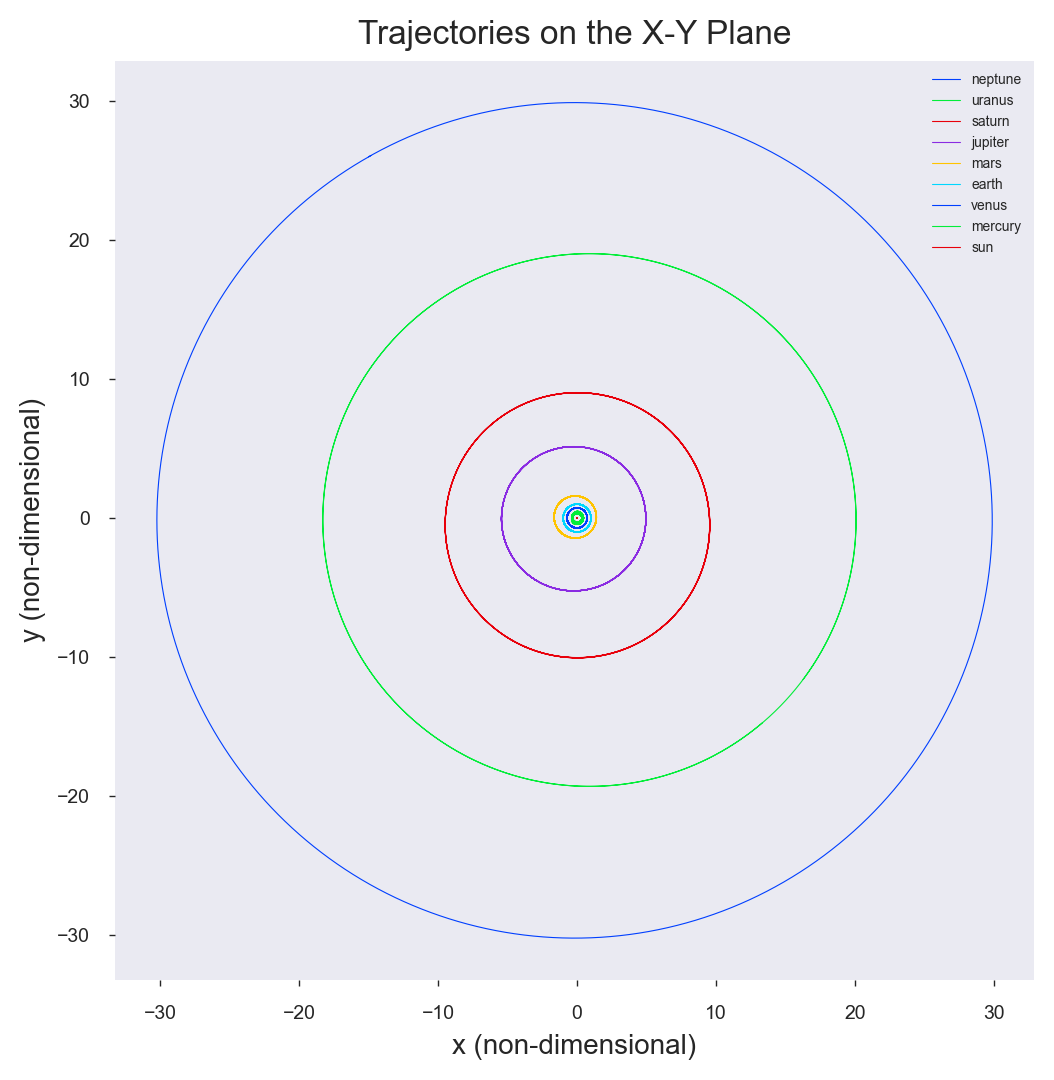

In [13]:
plt.style.use("seaborn-bright")
fig = plt.figure(dpi = 200)
ax = plt.subplot()
ax.set_aspect("equal")
i_s = [4, 5, 3, 2, 7, 1, 6, 8, 0]
for i in i_s:
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.4)
ax.legend(fontsize="5")
ax.set_xlabel("x (non-dimensional)", size=10)
ax.set_ylabel("y (non-dimensional)", size = 10)
ax.tick_params('both', length=2, width=0.5)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
plt.title('Trajectories on the X-Y Plane')
plt.grid(False)
plt.tight_layout()
plt.savefig("plot_x_y_plane.png")
plt.show()

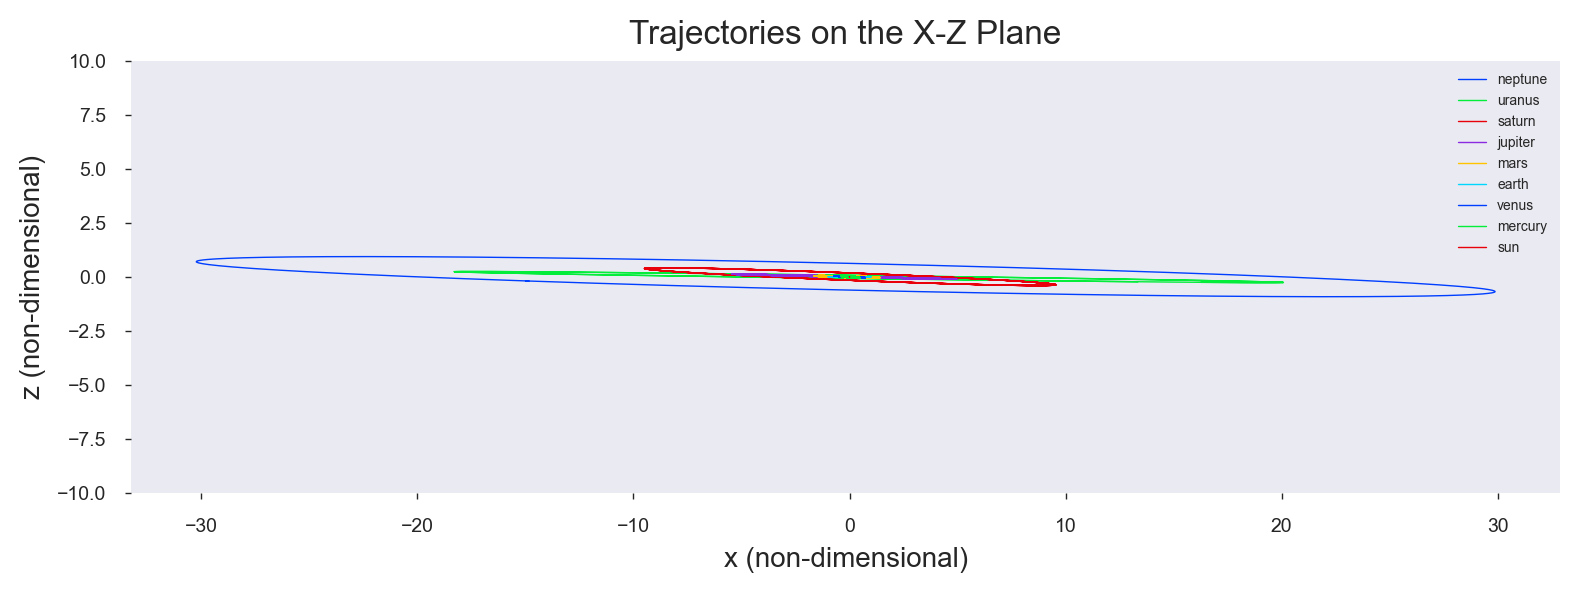

In [17]:
fig = plt.figure(dpi = 200)
fig.patch.set_alpha(0)
ax = plt.subplot()
ax.set_aspect("equal")
i_s = [4, 5, 3, 2, 7, 1, 6, 8, 0]
for i in i_s:
    ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
ax.set_ylim(-10, 10)
ax.legend(fontsize="5")
ax.set_xlabel("x (non-dimensional)", size=10)
ax.set_ylabel("z (non-dimensional)", size = 10)
ax.tick_params('both', length=2, width=0.5)
ax.tick_params(axis='x', labelsize=7)
ax.tick_params(axis='y', labelsize=7)
plt.title('Trajectories on the X-Z Plane')
# ax.patch.set_facecolor((243/256, 243/256, 241/256))
ax.patch.set_alpha(1)
plt.grid(False)
plt.tight_layout()
plt.savefig("aplot_x_z_plane.png")
plt.show()

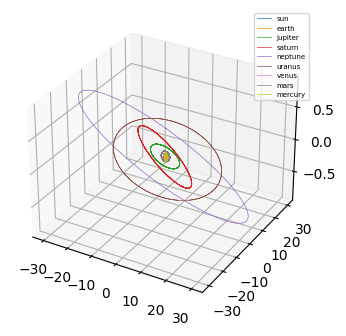

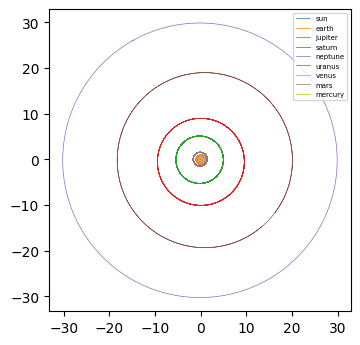

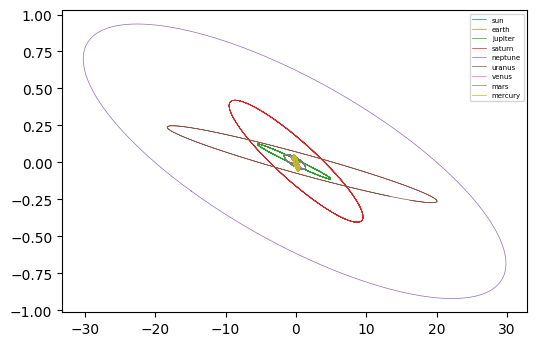

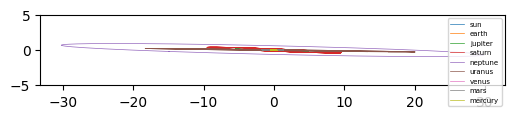

In [9]:
# ax = plt.figure(dpi = 100).add_subplot(projection='3d')
# for i in range(n_bodies):
#     ax.plot(x[i], y[i], z[i], label = bodies[i], linewidth = 0.5)
# ax.legend(fontsize="5")
# plt.show()

fig = plt.figure(dpi = 100)
ax = plt.subplot()
ax.set_aspect("equal")
for i in range(n_bodies):
    ax.plot(x[i], y[i], label = bodies[i], linewidth = 0.5)
ax.legend(fontsize="5")
plt.show()

# fig = plt.figure(dpi = 100)
# ax = plt.subplot()
# # ax.set_aspect("equal")
# for i in range(n_bodies):
#     ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
# ax.legend(fontsize="5")
# plt.show()

# fig = plt.figure(dpi = 100)
# ax = plt.subplot()
# ax.set_aspect("equal")
# for i in range(n_bodies):
#     ax.plot(x[i], z[i], label = bodies[i], linewidth = 0.5)
# ax.set_ylim(-5, 5)
# ax.legend(fontsize="5")
# plt.show()